In [61]:
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from scipy.stats import ttest_ind
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
DB_USERNAME = 'root'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'
DB_NAME = 'basketball'

In [63]:
# Database connection
engine = create_engine(
    f"mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}?charset=utf8mb4", 
    echo=False
)
Session = sessionmaker(bind=engine)
session = Session()

In [64]:
# Helper functions

def parse_height_to_inches(height_str):
    """
    This function convert heights to an integer (inches).
    """
    if not height_str:
        return None
    match = re.match(r"(\d+)-(\d+)", height_str)
    if match:
        feet = int(match.group(1))
        inches = int(match.group(2))
        return feet * 12 + inches
    else:
        return None

def get_top_n_players_by_points(season_id, n=20):
    # Returns a list of dictionaries for the top N players in a season based on 'points'. We join 'season_player' with 'players' to get height and weight.

    query = text("""
        SELECT sp.player_id, sp.points, p.player_height, p.player_weight 
        FROM season_player AS sp
        JOIN players AS p ON sp.player_id = p.player_id
        WHERE sp.season_id = :season_id
        ORDER BY sp.points DESC
        LIMIT :n
    """)
    result = session.execute(query, {"season_id": season_id, "n": n})
    rows = result.fetchall()

    data = []
    for row in rows:
        data.append({
            "player_id": row[0],
            "points": row[1],
            "height_str": row[2],
            "weight": row[3]
        })
    return data

def compute_agility(height_str, weight):

    # Computes "agility" = height_in_inches / weight.

    height_in_inches = parse_height_to_inches(height_str)
    if height_in_inches and weight > 0:
        return height_in_inches / weight
    else:
        return None

def compute_intrinsic_ability(season_id, first_year, birth_date_yyyymmdd):
    """
    Computes "intrinsic ability" = (experience) / (age).
      - experience = (season_id - first_year)
      - age = (season_id - birth_year)
    Here, birth_date_yyyymmdd is an integer of the form YYYYMMDD, so we extract the year by dividing by 10,000.
    """
    experience = season_id - first_year

    birth_year = birth_date_yyyymmdd // 10000  # e.g. 19840620 -> 1984
    age = season_id - birth_year
    if age > 0:
        return experience / age
    else:
        return None



Descriptive Comparison: Height Distribution
 -> Michael Jordan Trophy group has 23 players.
 -> Top-50 scorers group has 50 players.


C:\Users\2021\AppData\Local\Temp\ipykernel_12712\2321698896.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mj_heights, label='MJ Trophy Players', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\2021\AppData\Local\Temp\ipykernel_12712\2321698896.py:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top_50_heights, label='Top-50 Scorers', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remove

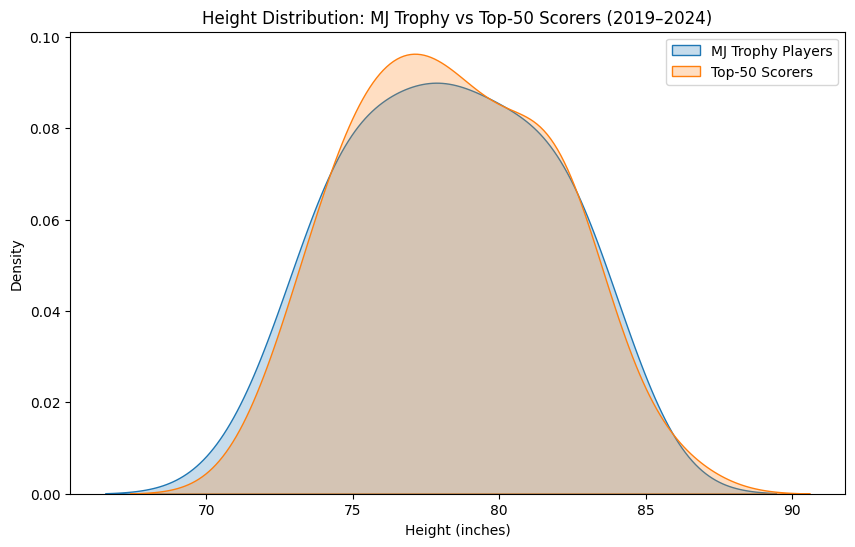

In [65]:
# Statistical Analysis
# 1) Compare the height distribution of:
#    (A) players in "Michael Jordan Trophy" list
#    (B) top 50 scorers over seasons from 2019–2020 to 2023–2024
#    We combine all these seasons' data (not separated by season).

def get_mj_trophy_players(season_start, season_end):
    """
    Fetches all players (and their heights) who got 'Michael Jordan Trophy' between the specified season_start and season_end (inclusive).
    Since 'Michael Jordan Trophy' is inside parentheses in trophy_name, we use SQL LIKE '%Michael Jordan Trophy%'.
    """
    q = text("""
        SELECT DISTINCT p.player_id, p.player_height
        FROM player_trophy pt
        JOIN awards a ON pt.trophy_id = a.trophy_id
        JOIN players p ON pt.player_id = p.player_id
        WHERE a.trophy_name LIKE '%Michael Jordan Trophy%'
          AND pt.season_id BETWEEN :start AND :end
    """)
    rows = session.execute(q, {"start": season_start, "end": season_end}).fetchall()
    return rows  # list of (player_id, player_height)

def get_top_n_players_by_points(season_id, n=20):
    """
    Fetches the top N players in a season by points. 
    If n is None, return all players for that season.
    """
    if n is None:
        # Fetch all players, without LIMIT
        query = text("""
            SELECT sp.player_id, sp.points, p.player_height, p.player_weight
            FROM season_player AS sp
            JOIN players AS p ON sp.player_id = p.player_id
            WHERE sp.season_id = :season_id
            ORDER BY sp.points DESC
        """)
        result = session.execute(query, {"season_id": season_id})
    else:
        # Fetch only top n players
        query = text("""
            SELECT sp.player_id, sp.points, p.player_height, p.player_weight
            FROM season_player AS sp
            JOIN players p ON sp.player_id = p.player_id
            WHERE sp.season_id = :season_id
            ORDER BY sp.points DESC
            LIMIT :n
        """)
        result = session.execute(query, {"season_id": season_id, "n": n})
    
    rows = result.fetchall()
    data = []
    for row in rows:
        data.append({
            "player_id": row[0],
            "points": row[1],
            "player_height": row[2],
            "player_weight": row[3]
        })
    return data






season_start = 2020  # 2019–2020
season_end   = 2024  # 2023–2024

# MJ trophy group:
mj_rows = get_mj_trophy_players(season_start, season_end)
mj_heights = [parse_height_to_inches(r[1]) for r in mj_rows if parse_height_to_inches(r[1])]

# Top 50 scorers (across all seasons combined):
top_50_rows = get_top_50_all_seasons(season_start, season_end)
top_50_heights = [parse_height_to_inches(height_str) for (_, height_str) in top_50_rows if parse_height_to_inches(height_str)]

print("\nDescriptive Comparison: Height Distribution")
print(f" -> Michael Jordan Trophy group has {len(mj_heights)} players.")
print(f" -> Top-50 scorers group has {len(top_50_heights)} players.")

# Visualizing the height distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(mj_heights, label='MJ Trophy Players', shade=True)
sns.kdeplot(top_50_heights, label='Top-50 Scorers', shade=True)
plt.title("Height Distribution: MJ Trophy vs Top-50 Scorers (2019–2024)")
plt.xlabel("Height (inches)")
plt.ylabel("Density")
plt.legend()
plt.show()


Champion Team vs. Top-15 Players (Last Two Seasons)


C:\Users\2021\AppData\Local\Temp\ipykernel_12712\4170372980.py:64: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(champion_experience, label='Champion Experience', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\2021\AppData\Local\Temp\ipykernel_12712\4170372980.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top15_experience, label='Top-15 Experience', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated an

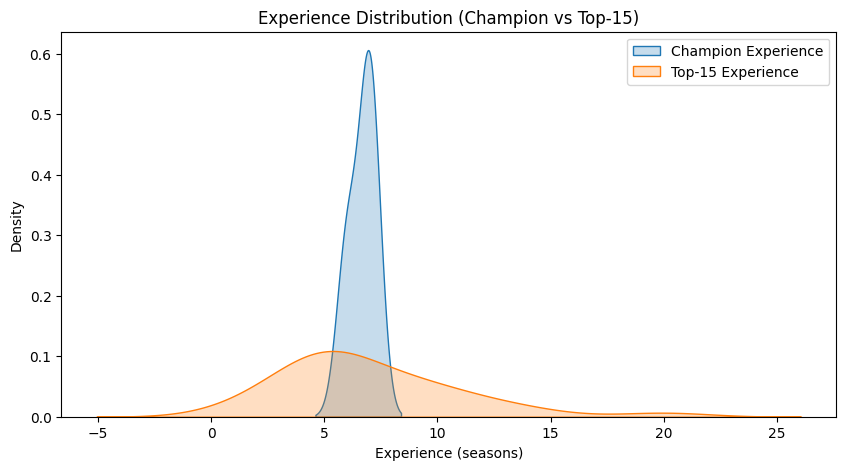

C:\Users\2021\AppData\Local\Temp\ipykernel_12712\4170372980.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(champion_heights, label='Champion Heights', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\2021\AppData\Local\Temp\ipykernel_12712\4170372980.py:75: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(top15_heights, label='Top-15 Heights', shade=True)
c:\Users\2021\anaconda3\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be re

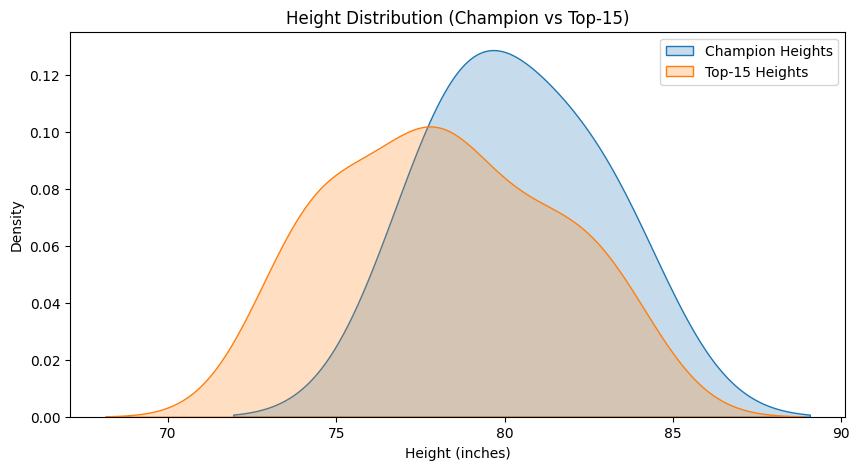

In [66]:
# 2) Compare the distribution of (experience, height) for:
#    - players in the champion team (last 2 seasons)
#    - top 15 players in that same season

last_two_seasons = [2023, 2024]

champion_experience = []
champion_heights = []
top15_experience = []
top15_heights = []

def get_team_players_in_season(season_id, team_id):
    q = text("""
        SELECT sp.player_id, p.player_first_year, p.player_birth_date, p.player_height
        FROM season_player sp
        JOIN players p ON sp.player_id = p.player_id
        WHERE sp.season_id = :sid
          AND sp.team_id = :tid
    """)
    rows = session.execute(q, {"sid": season_id, "tid": team_id}).fetchall()
    return rows  # ✅ Now includes (player_id, first_year, birth_date, player_height)


def compute_experience(season_id, first_year):
    """ Simple experience calculation: (season_id - first_year). """
    return season_id - first_year

for s in last_two_seasons:
    champ_team_id = get_champion_team(s)
    if champ_team_id:
        # 2A: Champion team players
        champ_players = get_team_players_in_season(s, champ_team_id)  # Ensure this function returns height!
        for (pid, first_year, birth_yyyymmdd, player_height) in champ_players:  # ✅ Now includes height
            # Experience
            exp_val = compute_experience(s, first_year)
            champion_experience.append(exp_val)

            # Height (check for None)
            if player_height:
                h_in = parse_height_to_inches(player_height)
                if h_in:
                    champion_heights.append(h_in)

        # 2B: Top 15 players in that same season
        top15 = get_top_n_players_by_points(s, 15)
        for tp in top15:
            # Experience - fetch first_year
            first_year_q = text("SELECT player_first_year FROM players WHERE player_id=:pid")
            r_exp = session.execute(first_year_q, {"pid": tp['player_id']}).fetchone()
            if r_exp:
                exp_val = compute_experience(s, r_exp[0])
                top15_experience.append(exp_val)

            # Height (fix: use 'player_height' instead of 'height_str')
            if tp['player_height']:  # ✅ Avoids NoneType error
                h_in = parse_height_to_inches(tp['player_height'])  # ✅ FIXED
                if h_in:
                    top15_heights.append(h_in)

print("\nChampion Team vs. Top-15 Players (Last Two Seasons)")

# Plot experience distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(champion_experience, label='Champion Experience', shade=True)
sns.kdeplot(top15_experience, label='Top-15 Experience', shade=True)
plt.title("Experience Distribution (Champion vs Top-15)")
plt.xlabel("Experience (seasons)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot height distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(champion_heights, label='Champion Heights', shade=True)
sns.kdeplot(top15_heights, label='Top-15 Heights', shade=True)
plt.title("Height Distribution (Champion vs Top-15)")
plt.xlabel("Height (inches)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [67]:
# 3) A club wants to sign a Point Guard (PG) with high ability, 
#    defined here as repeated presence in the "Michael Jordan Trophy" list
#    from 2019-20 to 2023-24. 
#    Provide a top-3 suggestion

def get_pg_mj_presence(season_start, season_end):
    # Returns a list of (player_id, pg_position, mj_count) for all PG players, counting how many times they appeared in 'Michael Jordan Trophy' between season_start and season_end.
    
    # We join 'players' (to check pos), 'player_trophy' (to see trophy presence),
    # and 'awards' (to ensure we only count MJ Trophy).
    # Then we group by player_id and count how many times they appear.
    q = text("""
        SELECT p.player_id, p.player_pos, COUNT(*) AS mj_appearances
        FROM player_trophy pt
        JOIN awards a ON pt.trophy_id = a.trophy_id
        JOIN players p ON pt.player_id = p.player_id
        WHERE a.trophy_name = 'Michael Jordan Trophy'
          AND pt.season_id BETWEEN :start AND :end
          AND p.player_pos = 'PG'
        GROUP BY p.player_id, p.player_pos
        ORDER BY mj_appearances DESC
    """)
    rows = session.execute(q, {"start": season_start, "end": season_end}).fetchall()
    return rows

pg_candidates = get_pg_mj_presence(2020, 2024)
# This is a list of (player_id, 'PG', mj_appearances)

print("\nClub's Request: Top PGs by MJ Trophy presence (2019–2024)")
if not pg_candidates:
    print("No PGs found who appeared in the Michael Jordan Trophy list in that range.")
else:
    # Show top 3
    top_3 = pg_candidates[:3]
    for i, row in enumerate(top_3, start=1):
        pid, pos, count = row
        print(f"#{i} -> Player ID: {pid}, Position: {pos}, MJ Trophy appearances: {count}")
    # We also want their names, so let's quickly fetch them:
    print("\nSuggested PGs:")
    for i, row in enumerate(top_3, start=1):
        pid, pos, count = row
        name_q = text("SELECT player_name FROM players WHERE player_id=:pid")
        name_res = session.execute(name_q, {"pid": pid}).fetchone()
        player_name = name_res[0] if name_res else "(unknown)"
        print(f"#{i} - {player_name} (ID={pid}), Appearances={count}")



Club's Request: Top PGs by MJ Trophy presence (2019–2024)
No PGs found who appeared in the Michael Jordan Trophy list in that range.


Hypothesis 1 (Agility):
t-statistic = -0.3928264554165745 , p-value = 0.695520296698132
=> Conclusion: No statistically significant difference found. (Fail to reject null)


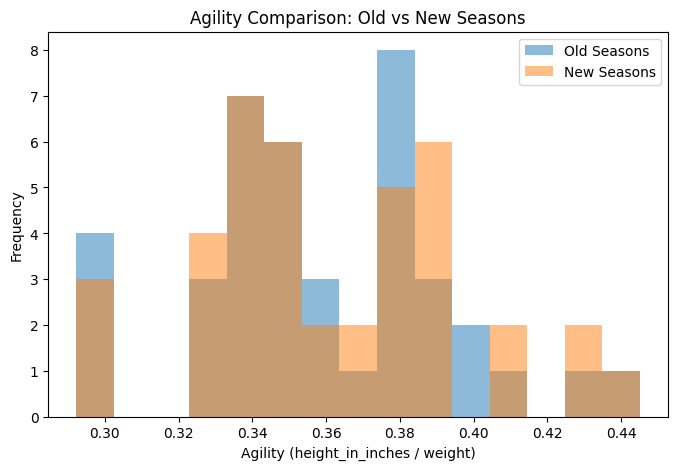

In [ ]:
# Hypothesis 1:
# "Has the average agility of top-20 players from the 2022-23 to 2023-24 seasons increased compared to the 2020-21 to 2021-22 seasons?"

old_seasons = [2021, 2022]  # 2020–21, 2021–22
new_seasons = [2023, 2024]  # 2022–23, 2023–24

old_agility_values = []
new_agility_values = []

# Collect agility values for old seasons (top 20 players each)
for s in old_seasons:
    top_players = get_top_n_players_by_points(s, 20)
    for tp in top_players:
        agility = compute_agility(tp['player_height'], tp['player_weight'])  
        if agility is not None:
            old_agility_values.append(agility)

# Collect agility values for new seasons (top 20 players each)
for s in new_seasons:
    top_players = get_top_n_players_by_points(s, 20)
    for tp in top_players:
        agility = compute_agility(tp['player_height'], tp['player_weight']) 
        if agility is not None:
            new_agility_values.append(agility)

# Perform t-test 
t_stat, p_value = ttest_ind(old_agility_values, new_agility_values, equal_var=False)
print("Hypothesis 1 (Agility):")
print("t-statistic =", t_stat, ", p-value =", p_value)
if p_value < 0.05:
    print("=> Conclusion: The difference in mean agility is significant. (Null hypothesis rejected)")
else:
    print("=> Conclusion: No statistically significant difference found. (Fail to reject null)")

# Visualize agility distributions with a single histogram
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(old_agility_values, alpha=0.5, bins=15, label='Old Seasons')
ax.hist(new_agility_values, alpha=0.5, bins=15, label='New Seasons')
ax.set_title("Agility Comparison: Old vs New Seasons")
ax.set_xlabel("Agility (height_in_inches / weight)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()



Hypothesis 2 (Intrinsic Ability in Champion Teams):
t-statistic = -0.57821483441942 , p-value = 0.6021288544000725
=> Conclusion: No statistically significant difference found. (Fail to reject null)


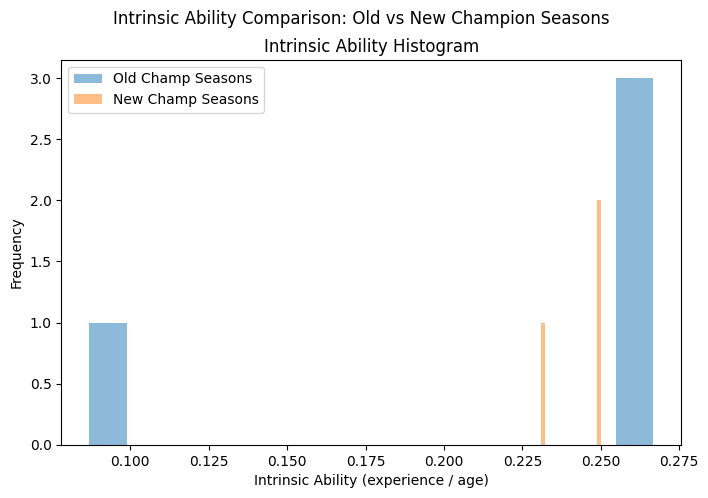

In [69]:
# Hypothesis 2:
# "Has the average intrinsic ability of the champion team's active players in the last two seasons (e.g., 2023 and 2024) increased compared to  the previous two (2021 and 2022)?"

old_champion_seasons = [2021, 2022]
new_champion_seasons = [2023, 2024]

def get_champion_team(season_id):
    # Retrieves 'season_champion_team' from the 'seasons' table.
    q = text("SELECT season_champion_team FROM seasons WHERE season_id=:sid")
    row = session.execute(q, {"sid": season_id}).fetchone()
    return row[0] if row else None

def get_team_players_in_season(season_id, team_id):
    # Fetches the players of a particular team in a given season from 'season_player' and joins with 'players' to get 'player_first_year' and 'player_birth_date'.
    q = text("""
        SELECT sp.player_id, p.player_first_year, p.player_birth_date
        FROM season_player sp
        JOIN players p ON sp.player_id = p.player_id
        WHERE sp.season_id = :sid
          AND sp.team_id = :tid
    """)
    rows = session.execute(q, {"sid": season_id, "tid": team_id}).fetchall()
    return rows

old_ability_values = []
new_ability_values = []

# Collect ability values for champion teams in old seasons
for s in old_champion_seasons:
    champion_team_id = get_champion_team(s)
    if champion_team_id:
        players_info = get_team_players_in_season(s, champion_team_id)
        for pi in players_info:
            # pi is (player_id, first_year, birth_date_yyyymmdd)
            ability = compute_intrinsic_ability(s, pi[1], pi[2])
            if ability is not None:
                old_ability_values.append(ability)

# Collect ability values for champion teams in new seasons
for s in new_champion_seasons:
    champion_team_id = get_champion_team(s)
    if champion_team_id:
        players_info = get_team_players_in_season(s, champion_team_id)
        for pi in players_info:
            ability = compute_intrinsic_ability(s, pi[1], pi[2])
            if ability is not None:
                new_ability_values.append(ability)

# Perform t-test
t_stat2, p_value2 = ttest_ind(old_ability_values, new_ability_values, equal_var=False)
print("\nHypothesis 2 (Intrinsic Ability in Champion Teams):")
print("t-statistic =", t_stat2, ", p-value =", p_value2)
if p_value2 < 0.05:
    print("=> Conclusion: The difference in mean intrinsic ability is significant. (Null hypothesis rejected)")
else:
    print("=> Conclusion: No statistically significant difference found. (Fail to reject null)")

# Visualize intrinsic ability distributions
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(old_ability_values, alpha=0.5, bins=15, label='Old Champ Seasons')
ax.hist(new_ability_values, alpha=0.5, bins=15, label='New Champ Seasons')
ax.set_title('Intrinsic Ability Histogram')
ax.set_xlabel("Intrinsic Ability (experience / age)")
ax.set_ylabel("Frequency")
ax.legend()

plt.suptitle("Intrinsic Ability Comparison: Old vs New Champion Seasons")
plt.show()
